In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

def minMaxScale(data, imposed_minimum = None, imposed_maximum = None, fit = False): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (imposed_minimum != None): mini = imposed_minimum
    if (imposed_maximum != None): maxi = imposed_maximum
    if (fit == False):
        return (data - mini)/(maxi - mini)
    else: 
        return [mini, maxi]

In [3]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)

In [4]:
print(len(data), len(data_profit))
display(data.sample(), data_profit.sample())

78684 49058


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
63753,Michael Clarke Duncan,M,1957-12-10,Slipstream,2007.0,27769.0,96.0,5.866667,11138,"[' ""Parody""', ' ""Science Fiction""', ' ""Drama""'...","[' ""United States of America""}']",32289.534884


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
19960,Josh Mostel,M,1946-12-21,Great Expectations,25000000,1998.0,55494066.0,100.0,7.444595,112206,"[' ""Romantic drama""', ' ""Romance Film""', ' ""Dr...","[' ""United States of America""}']",30494066.0,4.484421e+07


In [5]:
worst_profit = min(data_profit['profit_adj']) 
#worst movie
data_profit.query(f'profit_adj == {worst_profit}').sample()

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
376,Sam Hardy,M,1883-03-21,King Kong,207000000,1933.0,1856000.0,100.0,7.178571,543198,"[' ""Monster movie""', ' ""Horror""', ' ""Adventure...","[' ""United States of America""}']",-205144000.0,-4.102880e+09


# Star score calculation

first we need to deflate the imdb ratings by the amount of votes they've gotten

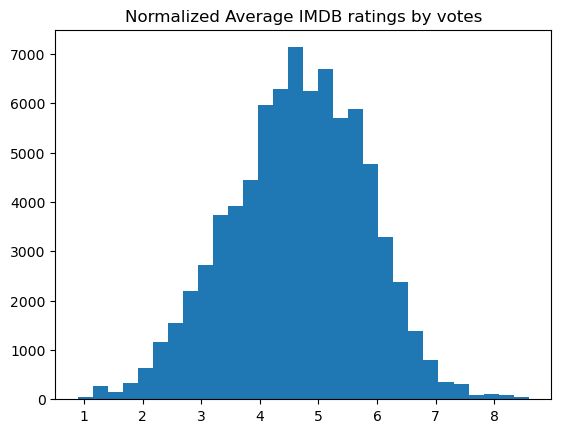

In [6]:
data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']
plt.hist(data['averageRating_adj'], bins = 30) #adjusted to the number of votes
plt.title("Normalized Average IMDB ratings by votes")
plt.show()

In [7]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split())) #simplifying actor names
star_scores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

In [8]:
for idx, actor in enumerate(star_scores['actor']):
    
    ds = data[data['actor'] == actor] #dataframe of all the actor's movies
    
    star_scores.loc[idx, 'rev_sum'] = ds['box_office_adj'].sum() #sum of the box offices of the actor's movies 
    star_scores.loc[idx, 'grade_sum'] = ds['averageRating_adj'].sum() #sum of the adjusted grades of the movies
    star_scores.loc[idx, 'appearances'] = len(ds) #total movies per actor

In [9]:
#small imprecision bc no months variables. flattening years together
timeScores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True))

In [10]:
longitudinal_interest_columns = {'box_office_adj': 'revenues',
                                 'Movie_release_date': 'movie_years', 'averageRating_adj': 'ratings'}

for idx, (key, value) in enumerate(longitudinal_interest_columns.items()):
    
    lists_per_actor = data.groupby('actor').apply(lambda x : pd.Series({key: x[key].values})).reindex(
        index = timeScores['actor'].values)
    timeScores[value] = lists_per_actor.values
    
#for col in longitudinal_interest_columns:
#    per_month[col] = selected_T4_ds.groupby('date_transformed').apply(lambda x: pd.Series({col: x[col].values }))

In [11]:
#to access a list :
#star_scores.query('actor == "Bruce_Willis"')['cumulative_revenue'].tolist()[0]
timeScores['cumulative_revenue'] = timeScores['revenues'].apply(lambda x : np.cumsum(x.tolist()))
timeScores['cumulative_ratings'] = timeScores['ratings'].apply(lambda x : np.cumsum(x.tolist()))

In [12]:
timeScores.query('actor == "Bruce_Willis"')

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings
6221,Bruce_Willis,"[134943125.0, 83663223.40425533, 287281542.857...","[1982.0, 1987.0, 1988.0, 1988.0, 1989.0, 1989....","[5.234449774801497, 4.962270978137284, 6.85023...","[134943125.0, 218606348.40425533, 505887891.26...","[5.234449774801497, 10.19672075293878, 17.0469..."


In [13]:
timeScores['star_score'] = timeScores.apply(lambda x : np.log(x['cumulative_revenue'] * x['cumulative_ratings']),
                                            axis = 1)

In [14]:
timeScores.query('actor == "Bruce_Willis"').star_score.tolist()[0]

array([20.37562569, 21.52484935, 22.87779702, 23.16592681, 24.12066325,
       24.26186786, 24.43932385, 24.56774033, 25.03784568, 25.2167668 ,
       25.30309363, 25.38607554, 25.46254964, 25.68328199, 25.77828745,
       26.036364  , 26.09157519, 26.17052271, 26.23243044, 26.31510454,
       26.5161436 , 26.64345161, 26.91925832, 27.00653395, 27.0804974 ,
       27.11396059, 27.16636472, 27.40796109, 27.51062805, 27.57391951,
       27.63694881, 27.68006898, 27.71417254, 27.74477298, 27.79129007,
       27.86342092, 27.88950847, 27.98411682, 27.99370224, 28.03477429,
       28.08933249, 28.11001812, 28.14921902, 28.18301391, 28.25491294,
       28.27493007, 28.30365168, 28.38355376, 28.41081851, 28.43201317,
       28.45794694, 28.47418312, 28.51160685, 28.53836884, 28.57960625,
       28.63199162, 28.65012713, 28.68002949, 28.71376861, 28.76268324])

In [15]:
#log product = sum of log, we are using this because we have 2 very heavy tailed distributions
star_scores['score'] = np.log(star_scores['rev_sum'] * star_scores['grade_sum']) 
epfl_scaler = minMaxScale(star_scores['score'], fit = True)
star_scores['score_epfl'] = (minMaxScale(star_scores['score']) * 5) + 1 #min max scaled to epfl standards
star_scores.head(3)

,actor,rev_sum,grade_sum,appearances,score,score_epfl
0,Dustin_Farnum,6.117500e+06,2.861536,1.0,16.678023,2.697314
1,Elmer_Clifton,1.250000e+09,4.791714,1.0,22.513298,4.217113
2,Robert_Harron,1.250000e+09,4.791714,1.0,22.513298,4.217113


In [16]:
timeScores['epfl_score'] = timeScores['star_score'].apply(
    lambda x: (5 * minMaxScale(x, epfl_scaler[0], epfl_scaler[1])) + 1)

In [17]:
display(timeScores.query('actor == "Bruce_Willis"').epfl_score.tolist()[0][-1],
        star_scores.query('actor == "Bruce_Willis"')['score_epfl'])

5.844767263785556

6221    5.844767
Name: score_epfl, dtype: float64

In [18]:
# lets get better parse on genres 
data['genres_corrected'] = data['genres'].apply(lambda x: str(x).split('"')[1::2])

In [19]:
list_to_join = data['genres_corrected'].values.tolist()

`Main genre per actor`

In [20]:
genres_per_actor = data.groupby('actor').apply(
    lambda x :pd.Series({'genres': x['genres_corrected'].values})).reindex(index = timeScores['actor'].values)

timeScores['genres'] = genres_per_actor.values

In [21]:
genres_per_actor['genre_total'] = genres_per_actor['genres'].apply(lambda x : sum(x, [])).apply(
    lambda x : ['NaN'] if len(x) == 0 else x)

In [22]:
genres_per_actor['count_values'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False)['count'].values)

In [23]:
genres_per_actor['unique_genres_order'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [24]:
genres_per_actor['main'] = genres_per_actor['unique_genres_order'].apply(lambda x : x[0])
genres_per_actor['secondary'] = genres_per_actor['unique_genres_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [37]:
genres_to_merge = genres_per_actor.reset_index(drop = True)

In [33]:
#train a decision tree on the best actors, or hand made labels to get more interesting genres than costume drama

In [38]:
timeScores['genres'] = genres_to_merge['unique_genres_order']
timeScores['genre_count'] = genres_to_merge['count_values']
timeScores['main_genre'] = genres_to_merge['main']
timeScores['2nd_genre'] = genres_to_merge['secondary']

In [39]:
timeScores

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre
0,Dustin_Farnum,[6117500.0],[1914.0],[2.861536471788676],[6117500.0],[2.861536471788676],[16.67802278277362],[2.6973142737054587],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",Black-and-white,Drama
1,Elmer_Clifton,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama
2,Robert_Harron,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama
3,Walter_Long,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama
4,Violet_Wilkey,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama
...,...,...,...,...,...,...,...,...,...,...,...,...
21919,Kathleen_Rose_Perkins,[4254150.0],[2012.0],[4.961153496857019],[4254150.0],[4.961153496857019],[16.86504380860075],[2.7460239490161618],"[Horror, Mystery, Thriller]","[1, 1, 1]",Horror,Mystery
21920,Bo_Barrett,[4254150.0],[2012.0],[4.961153496857019],[4254150.0],[4.961153496857019],[16.86504380860075],[2.7460239490161618],"[Horror, Mystery, Thriller]","[1, 1, 1]",Horror,Mystery
21921,Odeya_Rush,[52569528.125],[2012.0],[5.482187694944039],[52569528.125],[5.482187694944039],[19.47915143232918],[3.426868966392679],"[Comedy, Drama, Fantasy]","[1, 1, 1]",Comedy,Drama
21922,Kendall_Ryan_Sanders,[52569528.125],[2012.0],[5.482187694944039],[52569528.125],[5.482187694944039],[19.47915143232918],[3.426868966392679],"[Comedy, Drama, Fantasy]","[1, 1, 1]",Comedy,Drama


In [40]:
genres_per_actor.query('actor == "Bruce_Willis"')

,genres,genre_total,count_values,unique_genres_order,main,secondary
actor,,,,,,
Bruce_Willis,"[[Film adaptation, Drama, Courtroom Drama], [R...","[Film adaptation, Drama, Courtroom Drama, Roma...","[32, 28, 26, 23, 23, 22, 14, 9, 7, 6, 6, 6, 6,...","[Thriller, Action, Drama, Comedy, Crime Fictio...",Thriller,Action


In [41]:
timeScores.to_csv('../data/timeScores.csv')
star_scores.to_csv('../data/star_scores.csv')

In [ ]:
#subgenres
#drop low frequencies
#group genres 

## HUGE CHUNGUS DOWN BELOW

In [38]:
genres_list = sum(list_to_join, [])

In [49]:
df_genres = pd.DataFrame({'genres' : genres_list}) #len 433190

In [50]:
df_genres.drop_duplicates() #308 genres

,genres
0,Silent film
1,Western
2,Drama
3,Indie
4,Black-and-white
...,...
396581,Nature
414077,News
414421,Fictional film
417054,Bloopers & Candid Camera


In [58]:
genre_occurences = pd.DataFrame(df_genres.groupby(['genres']).size(), columns = ['count'])

In [59]:
genre_occurences['count_percentage'] = genre_occurences['count']/len(df_genres)
display(genre_occurences)

,count,count_percentage
genres,,
Absurdism,732,0.001690
Acid western,29,0.000067
Action,18710,0.043191
Action Comedy,916,0.002115
Action Thrillers,2103,0.004855
...,...,...
Workplace Comedy,506,0.001168
World History,3,0.000007
World cinema,3450,0.007964


In [66]:
genre_occurences.sort_values(by ='count_percentage', ascending = False).head(50)

,count,count_percentage
genres,,
Drama,41556,0.095930
Comedy,33827,0.078088
Thriller,20337,0.046947
Romance Film,20180,0.046585
Action,18710,0.043191
Action/Adventure,14525,0.033530
Crime Fiction,13189,0.030446
Adventure,12871,0.029712
Family Film,9574,0.022101
